# <center>Compressing Influence Matrix Using Sparse Only</center>

The dose influence matrix is a fundamental component in the optimization process, but its handling can introduce computational challenges. The original matrix, being dense, requires substantial computational resources to manage. Hence, sparse influence matrix is being used in planning acorss various TPS to avoid computational issue. But it often leads to sub-optimal solutions, thus comprimising accuracy and plan quality. Hence we introduce novel technique of compressing original dense matrix using Randomized Minor-Value Rectification(RMR)

1. Generating a plan utilizing the sparse matrix with naive threshold of 1% of max(A)
2. Compressed planning using RMR method.
3. Visualizing and evaluating plan


### 1) Generating a plan utilizing the sparse matrix

In [1]:
# !pip install -r requirements.txt

In [2]:
import sys
sys.path.append('../../PortPy')
sys.path.append('../')

In [3]:
import portpy.photon as pp
from compress_rtp.utils.get_sparse_only import get_sparse_only
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import scipy

In [4]:
# specify the patient data location.
data_dir = r'../../PortPy/data'
# Use PortPy DataExplorer class to explore PortPy data
data = pp.DataExplorer(data_dir=data_dir)

# pick a patient from the existing patient list to get detailed info (e.g., beam angles, structures).
data.patient_id = 'Lung_Patient_2'

ct = pp.CT(data)
structs = pp.Structures(data)

# If the list of beams are not provided, it uses the beams selected manually
# by a human expert planner for the patient (manually selected beams are stored in portpy data).
# Create beams for the planner beams by default
# for the customized beams, you can pass the argument beam_ids
# e.g. beams = pp.Beams(data, beam_ids=[0,10,20,30,40,50,60])
beams = pp.Beams(data, load_inf_matrix_full=True)

# In order to create an IMRT plan, we first need to specify a protocol which includes the disease site,
# the prescribed dose for the PTV, the number of fractions, and the radiation dose thresholds for OARs.
# These information are stored in .json files which can be found in a directory named "config_files".
# An example of such a file is 'Lung_2Gy_30Fx.json'. Here's how you can load these files:
protocol_name = 'Lung_2Gy_30Fx'
# load clinical criteria from the config files for which plan to be optimized
clinical_criteria = pp.ClinicalCriteria(data, protocol_name=protocol_name)

# Optimization problem formulation
protocol_name = 'Lung_2Gy_30Fx'
# Loading hyper-parameter values for optimization problem
opt_params = data.load_config_opt_params(protocol_name=protocol_name)
# Creating optimization structures (i.e., Rinds)
structs.create_opt_structures(opt_params=opt_params, clinical_criteria=clinical_criteria)
# Loading influence matrix
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams, is_full=True)

# create a plan using ct, structures, beams and influence matrix. Clinical criteria is optional
my_plan = pp.Plan(ct=ct, structs=structs, beams=beams, inf_matrix=inf_matrix, clinical_criteria=clinical_criteria)

Creating optimization structures.. It may take some time due to dilation
Optimization structures created!!
Creating BEV..
Loading full influence matrix..
Done


In [5]:
# run optimization with naive thresold of 1% of max(A)
# create cvxpy problem using the clinical criteria and optimization parameters
A = deepcopy(inf_matrix.A)
S_sparse = get_sparse_only(matrix=A, threshold_perc=1)
inf_matrix.A = S_sparse

In [6]:
# Run IMRT fluence map optimization
opt = pp.Optimization(my_plan, inf_matrix=inf_matrix, opt_params=opt_params)
opt.create_cvxpy_problem()
sol_sparse_naive = opt.solve(solver='MOSEK', verbose=True)

Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Oct 01 04:54:18 PM: Your problem has 67514 variables, 18 constraints, and 0 parameters.
(CVXPY) Oct 01 04:54:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 01 04:54:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 01 04:54:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 01 04:54:18 PM: Compiling problem (target solver=MOSEK).
(C

(CVXPY) Oct 01 04:58:24 PM: 21  5.6e-07  1.4e-03  5.2e-08  9.94e-01   8.315792019e+01   8.315785995e+01   2.5e-07  132.16
(CVXPY) Oct 01 04:58:26 PM: 22  4.1e-07  1.9e-03  3.3e-08  9.95e-01   7.979522896e+01   7.979518376e+01   1.8e-07  133.88
(CVXPY) Oct 01 04:58:27 PM: 23  2.4e-07  2.9e-03  1.4e-08  9.96e-01   7.587296751e+01   7.587294083e+01   1.1e-07  135.50
(CVXPY) Oct 01 04:58:29 PM: 24  1.6e-07  4.5e-03  8.1e-09  9.97e-01   7.428513118e+01   7.428511256e+01   7.2e-08  137.09
(CVXPY) Oct 01 04:58:30 PM: 25  9.3e-08  7.6e-03  3.5e-09  9.98e-01   7.283480831e+01   7.283479743e+01   4.1e-08  138.75
(CVXPY) Oct 01 04:58:32 PM: 26  4.7e-08  1.5e-02  1.3e-09  9.99e-01   7.189306607e+01   7.189306048e+01   2.1e-08  140.33
(CVXPY) Oct 01 04:58:34 PM: 27  3.7e-08  2.4e-02  8.8e-10  9.99e-01   7.169226949e+01   7.169226510e+01   1.6e-08  141.97
(CVXPY) Oct 01 04:58:35 PM: 28  7.8e-09  5.5e-02  8.7e-11  9.99e-01   7.114067861e+01   7.114067765e+01   3.5e-09  143.58
(CVXPY) Oct 01 04:58:39 

### 2) Generating plan ustilizing compression of Influence Matrix using Sparse plus low rank

Now instead of optimizing the plan using sparse influence matrix $ S $ we optimize it using sparse matrix obtained using RMR method discussed in (RMR)[]

In [7]:
# run optimization with thresold of 1% and sparsifying matrix using RMR method
# create cvxpy problem using the clinical criteria and optimization parameters
S_rmr = get_sparse_only(matrix=A, threshold_perc=1, compression='rmr')
inf_matrix.A = S_rmr
opt = pp.Optimization(my_plan, inf_matrix=inf_matrix, opt_params=opt_params)
opt.create_cvxpy_problem()
sol_sparse_rmr = opt.solve(solver='MOSEK', verbose=True)

Generating sparse matrix using RMR...
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Oct 01 05:01:09 PM: Your problem has 67514 variables, 18 constraints, and 0 parameters.
(CVXPY) Oct 01 05:01:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 01 05:01:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 01 05:01:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 01 05:01:09 PM: Compi

(CVXPY) Oct 01 05:17:25 PM: 22  4.5e-05  1.5e+05  6.0e-02  -9.49e-01  5.025849407e+09   5.025804258e+09   2.0e-05  541.94
(CVXPY) Oct 01 05:17:36 PM: 23  1.8e-05  5.8e+04  3.4e-02  -8.23e-01  6.927107274e+09   6.927025303e+09   8.0e-06  552.75
(CVXPY) Oct 01 05:17:46 PM: 24  5.1e-06  1.7e+04  9.8e-03  -3.48e-01  3.669626597e+09   3.669546434e+09   2.3e-06  563.20
(CVXPY) Oct 01 05:17:57 PM: 25  2.0e-06  6.4e+03  2.6e-03  4.51e-01   2.268889774e+09   2.268852911e+09   8.8e-07  574.23
(CVXPY) Oct 01 05:18:08 PM: 26  7.4e-07  2.4e+03  6.2e-04  7.85e-01   6.964032616e+08   6.963890114e+08   3.3e-07  585.36
(CVXPY) Oct 01 05:18:19 PM: 27  2.6e-07  8.3e+02  1.3e-04  9.23e-01   3.550318296e+08   3.550267322e+08   1.1e-07  595.70
(CVXPY) Oct 01 05:18:29 PM: 28  8.8e-08  2.8e+02  2.7e-05  9.74e-01   1.106141609e+08   1.106123500e+08   3.9e-08  606.00
(CVXPY) Oct 01 05:18:40 PM: 29  3.6e-08  1.2e+02  7.1e-06  9.93e-01   3.999210322e+07   3.999135481e+07   1.6e-08  616.72
(CVXPY) Oct 01 05:18:51 

### 3) Visualizing and evaluate plan with and without compression

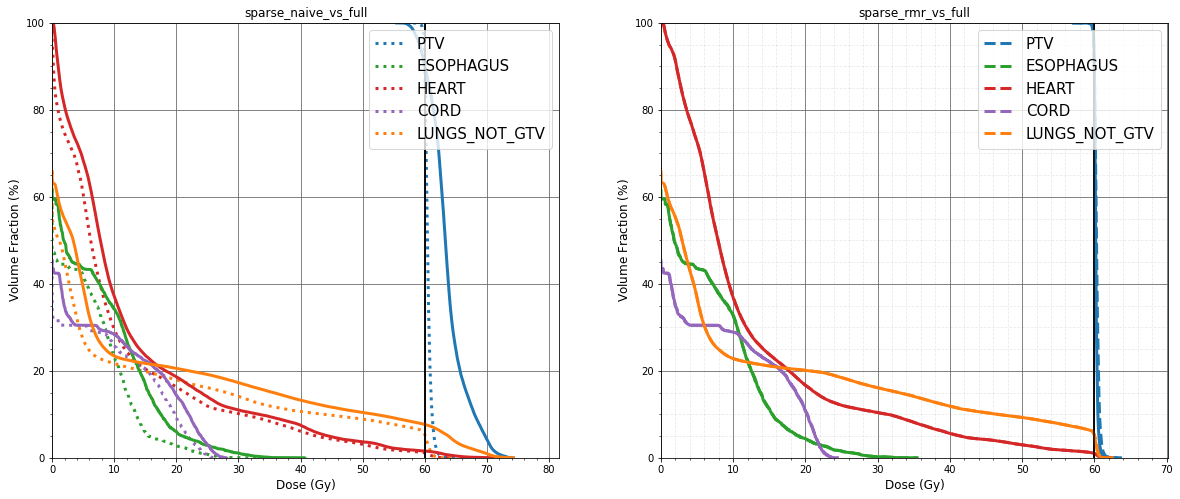

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD', 'LUNGS_NOT_GTV']
dose_1d_naive = (S_sparse @ sol_sparse_naive['optimal_intensity']) * my_plan.get_num_of_fractions()
dose_1d_full_naive = (A @ sol_sparse_naive['optimal_intensity']) * my_plan.get_num_of_fractions()
ax0 = pp.Visualization.plot_dvh(my_plan, dose_1d=dose_1d_naive, struct_names=struct_names, style='dotted', ax=ax[0], norm_flag=True)
ax0 = pp.Visualization.plot_dvh(my_plan, dose_1d=dose_1d_full_naive, struct_names=struct_names, style='solid', ax=ax0, norm_flag=True)
ax0.set_title("sparse_naive_vs_full")

dose_1d_rmr = (S_rmr @ sol_sparse_rmr['optimal_intensity']) * my_plan.get_num_of_fractions()
dose_1d_full_rmr = (A @ sol_sparse_rmr['optimal_intensity']) * my_plan.get_num_of_fractions()
ax1 = pp.Visualization.plot_dvh(my_plan, dose_1d=dose_1d_rmr, struct_names=struct_names, style='dashed', ax=ax[1], norm_flag=True)
ax1 = pp.Visualization.plot_dvh(my_plan, dose_1d=dose_1d_full_rmr, struct_names=struct_names, style='solid', ax=ax1, norm_flag=True)
ax1.set_title("sparse_rmr_vs_full")
plt.show(block=False)

In [9]:
# visualize plan metrics based upon clinical criteria
pp.Evaluation.display_clinical_criteria(my_plan, dose_1d=[dose_1d_full_naive, dose_1d_full_rmr], sol_names=['Naive Sparsification', 'RMR Sparsification'])

,constraint,structure_name,Limit,Goal,Naive Sparsification,RMR Sparsification
0,max_dose,GTV,69.0Gy,66.0Gy,83.57,61.06
1,max_dose,PTV,69.0Gy,66.0Gy,85.98,63.07
2,max_dose,ESOPHAGUS,66.0Gy,,47.09,35.30
3,mean_dose,ESOPHAGUS,34.0Gy,21.0Gy,7.64,6.00
4,V(60.0Gy),ESOPHAGUS,17.0%,,0.00,0.00
5,max_dose,HEART,66.0Gy,,82.40,62.25
6,mean_dose,HEART,27.0Gy,20.0Gy,14.29,12.20
7,V(30.0Gy),HEART,50.0%,,13.23,10.40
8,V(30.0Gy),HEART,,48.0%,13.23,10.40
9,max_dose,LUNG_L,66.0Gy,,18.39,15.61
